In [1]:
import numpy as np
import matplotlib.pyplot  as  plt
from matplotlib.ticker import MaxNLocator
from scipy.special import binom
from scipy.optimize import curve_fit
from matplotlib.markers import MarkerStyle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
fparams =  {'xtick.labelsize': 28,
            'ytick.labelsize': 28,
            'axes.labelsize': 32,
            'axes.titlesize': 28,
            'font.size': 28,
            'legend.fontsize': 26,
            'text.usetex': True,
            'legend.frameon' : False,
            'svg.fonttype': 'path'}

$p_l^{\,\beta} = \dfrac{\exp(-\beta \, \varepsilon_l)}{\sum\limits_l \exp(-\beta \, \varepsilon_l)}$

$\varepsilon_l$ -- many-body energy levels

$\omega_j$ -- single-particle energy levels

In [3]:
%run "C:\Users\Nick\Projects\thermalization_sim\v7\thermalizer.py" 

In [4]:
num = [4] # -- number of qubits
num_ex = [i for i in range(0, 16)] # -- number of the initial state. It ranges from 0 to 2^N - 1.
nr = 100 # -- number of realizations

time = np.load('data/time.npy', allow_pickle = True)

energ = {}
sp_levels = {}
es = {}
p = {}
pav = {}
err_av = {}
E = {}
E2 ={}
S = {}
Eav = {}
Sav = {}
E_in ={}

for n in range(len(num)):
    sp_levels[n] = np.load('data/sp_levels_N={}.npy'.format(num[n]), allow_pickle = True)
    energ[n] = np.load('data/energ_N={}.npy'.format(num[n]), allow_pickle = True)
    E_in[n] = np.load('data/initial_N={}.npy'.format(num[n]), allow_pickle = True)
    for m in range(len(num_ex)):
        es[n, m] = np.load('data/es_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        p[n, m] = np.load('data/p_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        pav[n, m] = np.load('data/pav_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        err_av[n, m] = np.load('data/err_av_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        E[n, m] = np.load('data/E_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        E2[n, m] = np.load('data/E2_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        S[n, m] = np.load('data/S_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        Eav[n, m] = np.load('data/Eav_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)
        Sav[n, m] = np.load('data/Sav_N={}_M={}_nr={}.npy'.format(num[n], num_ex[m], nr), allow_pickle = True)

In [5]:
def p_fit(es, x):
    f = np.exp( - x * es )
    Z = np.sum(f)
    f = f / Z
    return f

In [6]:
S_diag = {}
for n in range(len(num)):
    for m in range(len(num_ex)):
        S0 = [0]
        for tau in range(1,len(time)):
            S0.append(- pav[n,m][tau] @ np.log(pav[n,m][tau]))
        S_diag[n,m] = np.array(S0) 

In [7]:
num_ind = 0
dt_ind = 50
print(time[dt_ind])

beta_fit = {}
beta_err = {}
for n in range(len(num)):
    for m in range(len(num_ex)):
        beta_array = np.zeros(len(time))
        err_array = np.zeros(len(time))
        for t in range(dt_ind, len(time)):
            popt, pcov = curve_fit(p_fit, energ[num_ind], pav[num_ind, m][t], sigma = err_av[num_ind, m][t], absolute_sigma = True)
            beta_array[t] = popt
            err_array[t] = pcov
        beta_fit[n, m] = beta_array
        beta_err[n, m] = err_array

2.5


In [8]:
num_ind = 0
dt_ind = 50
print(time[dt_ind])

E_in_arr = E_in[num_ind]

beta_i = []
err_beta_i = []
for m in range(2 ** num[num_ind]):
    popt, pcov = curve_fit(p_fit, energ[num_ind], np.mean(pav[num_ind, m][dt_ind:], 0), 
                           sigma = np.mean(err_av[num_ind, m][dt_ind:], 0), absolute_sigma = True)
    beta_i.append(popt[0])    
    err_beta_i.append(pcov[0][0])
    
beta_i_arr = np.array(beta_i)  
err_beta_i_arr = np.sqrt(np.array(err_beta_i))

def FS_diag(i0, i1):
    c = np.log(np.sum(np.exp( - beta_i_arr[i1] * energ[i0] )))
    FS_diag = [c]
    for t in range(1, len(time)):
        f = c + pav[i0, i1][t] @ np.log( pav[i0, i1][t] )
        FS_diag.append(f)
    return np.array(FS_diag)

def S_err(i0, i1):
    f = np.mean(np.mean(E2[i0, i1], 1)[dt_ind:], 0) - np.mean(np.mean(E[i0, i1], 1)[dt_ind:], 0) ** 2
    return f

S_err_list = []
for m in range(2 ** num[num_ind]):
    S_err_list.append(S_err(num_ind, m))
S_err_arr = np.abs(err_beta_i_arr * beta_i_arr) * np.array(S_err_list)    

2.5


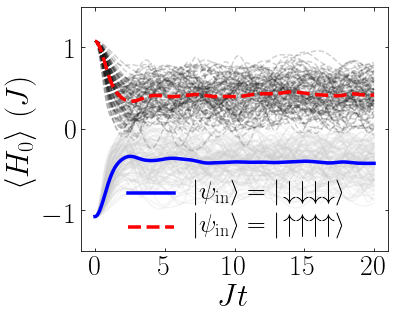

In [9]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_ylabel(r'$\langle H_0 \rangle\,\, (J)$')
ax.set_xlabel(r'$J t$')
num_ind = 0
n_init = [0, 15]
for j in range(nr):
    ax.plot(time, np.transpose(E[num_ind, n_init[0]])[j], '-', color='0.8', alpha = 0.2)
for j in range(nr):
    ax.plot(time, np.transpose(E[num_ind, n_init[1]])[j], '--', color='0.1', alpha = 0.2)
ax.plot(time, Eav[num_ind, n_init[0]],  '-', color = 'blue', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$')
ax.plot(time, Eav[num_ind, n_init[1]],  '--', color = 'red', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\uparrow \uparrow \uparrow \uparrow\rangle$')
ax.legend(loc = (0.12, 0.), ncol = 1, labelspacing = 0.25, handlelength = 1.75)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_ylim([-1.5, 1.5])
ax.set_xticks(np.arange(0, 21, 5))
plt.show()

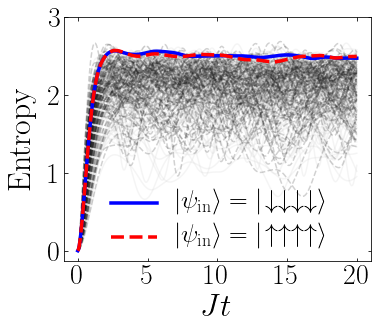

In [10]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_ylabel(r'$\rm Entropy$', labelpad=12)
ax.set_xlabel(r'$J t$')
n_init = [0, 15]
for j in range(nr):
    ax.plot(time, np.transpose(S[num_ind, n_init[0]])[j], '-', color='0.8', alpha = 0.2)
for j in range(nr):
    ax.plot(time, np.transpose(S[num_ind, n_init[1]])[j], '--', color='0.1', alpha = 0.2)
ax.plot(time, S_diag[num_ind, n_init[0]],  '-', color = 'blue', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$')
ax.plot(time, S_diag[num_ind, n_init[1]],  '--', color = 'red', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\uparrow \uparrow \uparrow \uparrow\rangle$')
ax.legend(loc = (0.12, 0), ncol = 1, labelspacing = 0.25, handlelength = 1.75)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_xticks(np.arange(0, 21, 5))
ax.set_yticks(np.arange(0, 4, 1))
plt.show()

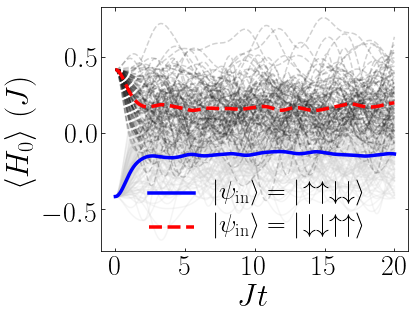

In [11]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_ylabel(r'$\langle H_0 \rangle\,\, (J)$')
ax.set_xlabel(r'$J t$')
num_ind = 0
n_init = [10, 5]
ax.set_xlabel(r'$J t$')
for j in range(nr):
    ax.plot(time, np.transpose(E[num_ind, n_init[0]])[j], '-', color='0.8', alpha = 0.2)
for j in range(nr):
    ax.plot(time, np.transpose(E[num_ind, n_init[1]])[j], '--', color='0.1', alpha = 0.2)
ax.plot(time, Eav[num_ind, n_init[0]],  '-', color = 'blue', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \downarrow \downarrow\rangle$')
ax.plot(time, Eav[num_ind, n_init[1]],  '--', color = 'red', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\downarrow \downarrow\uparrow \uparrow \rangle$')
ax.legend(loc = (0.12, 0.), ncol = 1, labelspacing = 0.25, handlelength = 1.75)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_xticks(np.arange(0, 21, 5))
plt.show()

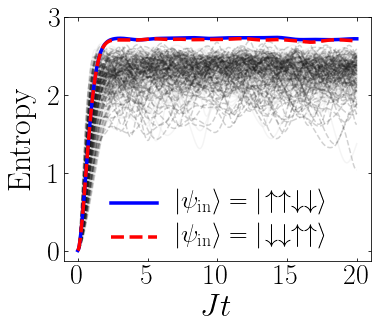

In [12]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_ylabel(r'$\rm Entropy$', labelpad=12)
ax.set_xlabel(r'$J t$')
n_init = [10, 5]
for j in range(nr):
    ax.plot(time, np.transpose(S[num_ind, n_init[0]])[j], '-', color='0.8', alpha = 0.2)
for j in range(nr):
    ax.plot(time, np.transpose(S[num_ind, n_init[1]])[j], '--', color='0.1', alpha = 0.2)   
ax.plot(time, S_diag[num_ind, n_init[0]],  '-', color = 'blue', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \downarrow \downarrow\rangle$')    
ax.plot(time, S_diag[num_ind, n_init[1]],  '--', color = 'red', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\downarrow \downarrow \uparrow \uparrow\rangle$')
ax.legend(loc = (0.12, 0), ncol = 1, labelspacing = 0.25, handlelength = 1.75)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_xticks(np.arange(0, 21, 5))
ax.set_yticks(np.arange(0, 4, 1))
plt.show()

In [13]:
t_ind2 = 200
print(time[t_ind2])

10.0


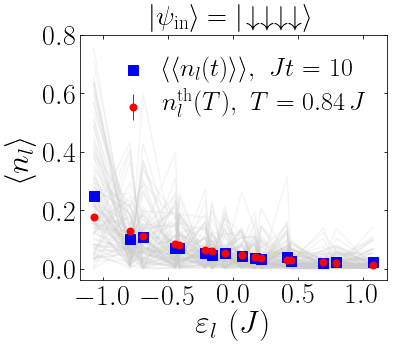

In [14]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_title(r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$')
ax.set_ylabel(r'$\langle n_l\rangle$')
ax.set_xlabel(r'$\varepsilon_l\,\, (J)$')
n_init=0
for j in range(nr):
    ax.plot(es[num_ind, n_init][t_ind2][j], p[num_ind, n_init][t_ind2][j],  '-', color='0.8', alpha = 0.2, 
             zorder = j)  
ax.plot(energ[num_ind], pav[num_ind, n_init][t_ind2], 's', color = 'blue', markersize = 10, zorder = nr + 1, 
         label = r'$\langle\langle n_l(t)\rangle\rangle, \,\, Jt = $'+' ${}$'.format(int(time[t_ind2])))
popt, pcov = curve_fit(p_fit, energ[num_ind], pav[num_ind, n_init][t_ind2], 
                       sigma = err_av[num_ind, n_init][t_ind2], absolute_sigma = True)
p_err = np.abs(np.sqrt(pcov[0]) * p_fit(popt[0], energ[num_ind]) * 
               (energ[num_ind] - p_fit(popt[0], energ[num_ind]) @ energ[num_ind]))
ax.errorbar(energ[num_ind], p_fit(popt[0], energ[num_ind]), fmt = '.',
         yerr = p_err, markersize = 12, color = 'red', markeredgewidth = 2,
         elinewidth=1, barsabove = True, zorder = nr + 2, 
         label = r'$n_l^{\rm th}(T),\,\,T = $'+' ${}\,J$'.format(np.round(1. / popt[0], 2)))
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.legend(loc = 1, handletextpad=0.1, labelspacing = 0.25)
ax.set_yticks(np.arange(0, 1.0, 0.2))
ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

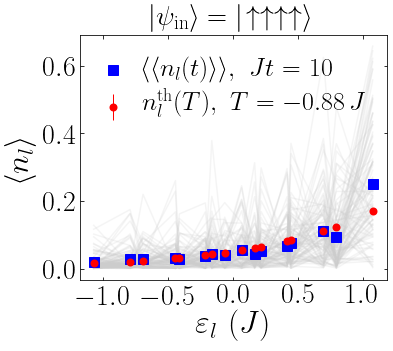

In [15]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_title(r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \uparrow \uparrow\rangle$')
ax.set_ylabel(r'$\langle n_l\rangle$')
ax.set_xlabel(r'$\varepsilon_l\,\, (J)$')
n_init = 15
for j in range(nr):
    ax.plot(es[num_ind, n_init][t_ind2][j], p[num_ind, n_init][t_ind2][j],  '-', color='0.8', alpha = 0.2, 
             zorder = j)  
ax.plot(energ[num_ind], pav[num_ind, n_init][t_ind2], 's', color = 'blue', markersize = 10, zorder = nr + 1, 
         label = r'$\langle\langle n_l(t)\rangle\rangle, \,\, Jt = $'+' ${}$'.format(int(time[t_ind2])))
popt, pcov = curve_fit(p_fit, energ[num_ind], pav[num_ind, n_init][t_ind2],
                       sigma = err_av[num_ind, n_init][t_ind2], absolute_sigma = True)
p_err = np.abs(np.sqrt(pcov[0]) * p_fit(popt[0], energ[num_ind]) * 
               (energ[num_ind] - p_fit(popt[0], energ[num_ind]) @ energ[num_ind]))
ax.errorbar(energ[num_ind], p_fit(popt[0], energ[num_ind]), fmt = '.',
         yerr = p_err, markersize = 12, color = 'red', markeredgewidth = 2,
         elinewidth=1, barsabove = True, zorder = nr + 2, 
         label = r'$n_l^{\rm th}(T),\,\,T = $'+' ${}\,J$'.format(np.round(1. / popt[0], 2)))
ax.tick_params(which='major', direction="in", top = "True", right = "True")
ax.tick_params(which='minor', direction="in")
ax.legend(loc = 1, handletextpad=0.1, labelspacing = 0.25)
ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

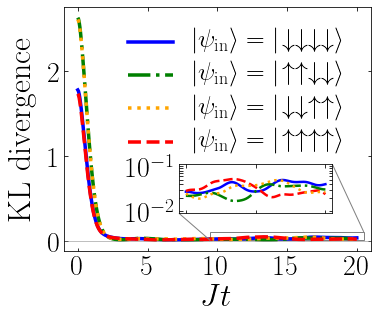

In [16]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
axins = ax.inset_axes([0.375, 0.155, 0.5, 0.2])
num_ind = 0
n_init = [0, 15, 10, 5] 
ax.set_xlabel(r'$J t$')
ax.set_ylabel(r'$\rm KL \,\, divergence$', labelpad = 12)
ax.plot(time, beta_i_arr[n_init[0]] * Eav[num_ind, n_init[0]] + FS_diag(num_ind, n_init[0]),  
         '-', color = 'blue', linewidth = 3.5,
         label = r'$|\psi_{\rm in}\rangle=|\!\downarrow \downarrow \downarrow \downarrow\rangle$')
ax.plot(time, beta_i_arr[n_init[2]] * Eav[num_ind, n_init[2]] + FS_diag(num_ind, n_init[2]),  
         '-.', color = 'green', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle=|\!\uparrow \uparrow \downarrow \downarrow\rangle$')
ax.plot(time, beta_i_arr[n_init[3]] * Eav[num_ind, n_init[3]] + FS_diag(num_ind, n_init[3]),  
         ':', color = 'orange', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\downarrow \downarrow \uparrow \uparrow\rangle$')
ax.plot(time, beta_i_arr[n_init[1]] * Eav[num_ind, n_init[1]] + FS_diag(num_ind, n_init[1]),  
         '--', color = 'red', linewidth = 3.5, 
         label = r'$|\psi_{\rm in}\rangle = |\!\uparrow \uparrow \uparrow \uparrow\rangle$')
ax.legend(loc = 1, ncol =1, labelspacing = 0.25, handlelength = 1.75)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticks(np.arange(0, 21, 5))
ax.axhline(color='gray', lw=0.5)
axins.plot(time[t_ind2:], beta_i_arr[n_init[0]] * Eav[num_ind, n_init[0]][t_ind2:] 
           + FS_diag(num_ind, n_init[0])[t_ind2:], '-', color = 'blue', linewidth = 2.5)
axins.plot(time[t_ind2:], beta_i_arr[n_init[1]] * Eav[num_ind, n_init[1]][t_ind2:] 
           + FS_diag(num_ind, n_init[1])[t_ind2:], '--', color = 'red', linewidth = 2.5)
axins.plot(time[t_ind2:], beta_i_arr[n_init[2]] * Eav[num_ind, n_init[2]][t_ind2:] 
           + FS_diag(num_ind, n_init[2])[t_ind2:], '-.', color = 'green', linewidth = 2.5)
axins.plot(time[t_ind2:], beta_i_arr[n_init[3]] * Eav[num_ind, n_init[3]][t_ind2:] 
           + FS_diag(num_ind, n_init[3])[t_ind2:], ':', color = 'orange', linewidth = 2.5)
axins.tick_params(which='major', direction="in", top = "True", right = "True"); 
axins.tick_params(which='minor', direction="in")
axins.set_xticks([10, 15, 20])
axins.set_ylim([0.009, 0.11])
axins.set_yscale('log')
axins.set_yticks([1e-1, 9e-2, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2, 1e-2])
mark_inset(ax, axins, loc1=3, loc2=1, ec='gray')
plt.setp(axins.get_xticklabels(), visible=False)
plt.show()

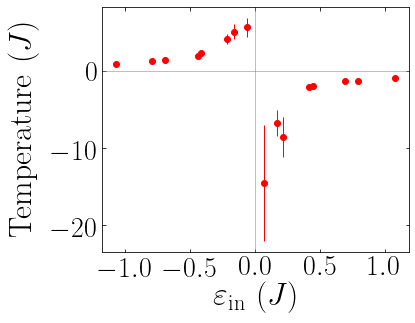

In [17]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()
ax.set_xlabel(r'$\varepsilon_{\rm in}\,\, (J)$')
ax.set_ylabel(r'${\rm Temperature} \,\, (J)$', labelpad = 12)
ax.errorbar(E_in_arr, 1/beta_i_arr, fmt = '.', 
             yerr = np.abs(err_beta_i_arr) / beta_i_arr ** 2, 
             markersize = 12, color = 'red', elinewidth=1, barsabove = True)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_xticks(np.arange(-1., 1.5, 0.5))
ax.axhline(color='gray', lw=0.5)
ax.axvline(color='gray', lw=0.5)
plt.show()

In [18]:
Sav_arr = np.array([np.mean(Sav[num_ind, m][dt_ind:]) for m in range(16)])
Sav_th_arr = np.array([- np.mean(pav[num_ind, m][dt_ind:],0) @ np.log(np.mean(pav[num_ind, m][dt_ind:],0)) 
                       for m in range(16)])
S_th_arr = np.array([- p_fit(beta_i_arr[m], energ[num_ind]) @ np.log(p_fit(beta_i_arr[m], energ[num_ind])) 
                     for m in range(16)])

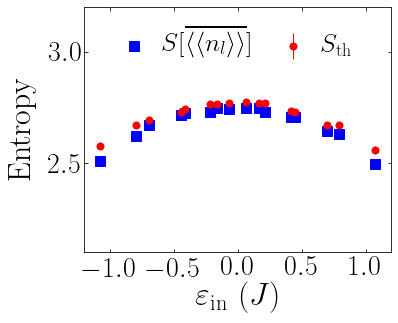

In [19]:
plt.rcParams.update(fparams)
fig = plt.figure(figsize=(5.5, 4.5))
ax = fig.add_subplot()

ax.set_xlabel(r'$\varepsilon_{\rm in}\,\, (J)$')
ax.set_ylabel(r'$\rm Entropy$', labelpad = 12)
ax.plot(E_in_arr, Sav_th_arr, 's', color = 'blue', markersize = 10,
          label = r'$ S\bigg[\overline{\langle \langle n_l \rangle\rangle}\bigg] $', zorder=0)
ax.errorbar(E_in_arr, S_th_arr, fmt = '.',
             yerr = S_err_arr, 
             markersize = 12, color = 'red', markeredgewidth = 2,
             elinewidth=1, barsabove = True, label = r'$ S_{\rm th} $', zorder=1)
ax.legend(loc=2, ncol = 2, columnspacing=0.5, handletextpad=0.1)
ax.tick_params(which='major', direction="in", top = "True", right = "True"); 
ax.tick_params(which='minor', direction="in")
ax.set_ylim([2.1, 3.2])
ax.set_xlim([-1.2, 1.2])
ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()